We aim to use `RADAR` to do differential analysis of m6A peaks. I'm starting from `fastq` raw data to align them using `STAR`; then I will use `bam` files to run `RADAR` and explore the results for downstream analysis.

I needed to re-build `STAR` indices as I've described in my notebook at `genomes/build-genome.ipynb` (see my GitHub repo). 

# Alignment task - Running `STAR`

https://hbctraining.github.io/Intro-to-rnaseq-hpc-O2/lessons/03_alignment.html

In [14]:
# STAR --runThreadN 6 \
#     --runMode genomeGenerate \
#     --genomeDir STAR.index \
#     --genomeFastaFiles GRCh37.primary_assembly.genome.fa \
#     --sjdbGTFfile DAC_GRCh37_merged.gtf \
#     --sjdbOverhang 99

In [4]:
cat star.sh

index=$1
bamDIR=$2

mkdir -p ${bamDIR}
mkdir -p ${bamDIR}_star_qc

STAR --genomeLoad LoadAndExit --genomeDir $index

for fq in fastq/*R1*; do
    fq=`basename $fq`
    echo '------------' $fq '-----------'
    out=${fq/_R1*/}
    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN 18 \
    --genomeDir $index \
    --readFilesIn fastq/$fq \
    --outFileNamePrefix ${bamDIR}/$out
done

STAR --genomeLoad Remove --genomeDir $index

rm -vr _STARtmp/ Aligned.out.sam Log.out Log.progress.out


In [1]:
!which STAR

/rumi/shams/abe/anaconda3/envs/alignment/bin/STAR


In [6]:
# !bash star.sh ../scallop-genome/STAR.index bam_scallop

# Peak calling task - Running `RADAR`

https://scottzijiezhang.github.io/RADARmanual/workflow.html

In [2]:
!mkdir radar_scallop

In [ ]:
# %load_ext rpy2.ipython

In [1]:
# %%R 
suppressMessages(suppressWarnings(library (RADAR)))

In [2]:
GTF = '../../scallop-genome/DAC_GRCh37_merged.gtf'

### 1. load `bam` files and make `MeRIP.RADAR` object
I'll save the object for later usage while it takes long time to generate. 

In [4]:
# %%R 
radar <- countReads(
	samplenames=c('U1','U2','T1','T2'), 
    annotation = GTF,
	bamFolder='./align/bam_scallop/',modification = "m6A", 
    strandToKeep = "opposite",
    outputDir='radar_scallop', 
    threads = 30
) 

[1] "Stage: index bam file ./align/bam_scallop//U1.input.bam"
[1] "Stage: index bam file ./align/bam_scallop//U1.m6A.bam"
[1] "Stage: index bam file ./align/bam_scallop//U2.input.bam"
[1] "Stage: index bam file ./align/bam_scallop//U2.m6A.bam"
[1] "Stage: index bam file ./align/bam_scallop//T1.input.bam"
[1] "Stage: index bam file ./align/bam_scallop//T1.m6A.bam"
[1] "Stage: index bam file ./align/bam_scallop//T2.input.bam"
[1] "Stage: index bam file ./align/bam_scallop//T2.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 30 thread(s) to count reads in continuous bins...
Time used to count reads: 15.0573156754176 mins... 


In [5]:
# %%R 
saveRDS(radar, 'radar_scallop/rawObj.rds')

In [6]:
# %%R 
summary(radar)

MeRIP dataset of 4 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
         U1    U2    T1    T2
Input 21.71 26.67 23.38 21.27
IP    34.08 32.36 38.46 39.72


___

### 2. Running RADAR pre processing commands 
https://scottzijiezhang.github.io/RADARmanual/Mannual.html

Final object after this step also saved into `radar/finalObj.rds`.

In [7]:
# %reload_ext rpy2.ipython

In [1]:
# %%R 
suppressMessages(suppressWarnings(library (RADAR)))

In [9]:
radar0 <- readRDS('radar_scallop/rawObj.rds')

In [10]:
radar0 <- normalizeLibrary(radar0, boxPlot=0)

In [11]:
radar0 <- adjustExprLevel(radar0)
# radar <- adjustExprLevel(radar, adjustBy = "pos")

# If you expect intensive alternative splicing events cross the experimental groups, 
# using gene-level read counts to represent pre-IP RNA level could leads to bias. 
# Therefore, the user can also choose to use the local bin-level read count to adjust 
# the pre-IP RNA level variation

variable(radar0) <- data.frame( group = c(rep("Untreated",2),rep("Treated",2)))

Adjusting expression level using Input geneSum read count...


In [12]:
radar0 <- filterBins(radar0,minCountsCutOff = 0)

radar0 <- diffIP_parallel(radar0,thread = 30)
saveRDS(radar0, 'radar_scallop/finalObj.rds')

Filtering bins with low read counts...
Bins with average counts lower than  0  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
Untreated Untreated   Treated   Treated 
        0         0         1         1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 30 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.809651660919189 mins... 



### 4. Get results and select significant bins

Results for all data (no filtering):

In [13]:
# %%R 
# radar0 <- readRDS('radar_scallop/finalObj.rds')

In [14]:
radar_all <- reportResult(radar0, cutoff = 1.1, Beta_cutoff = 0.00, threads=18)

result_all <- results(radar_all)
rm(radar0)

Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 4.74480501413345 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 41143 reported differential loci at FDR < 1.1 and logFoldChange > 0.


> Due to the resolution of the MeRIP-seq experiment where RNA molecules are fragmented into 100-300nt, neighboring bins can usually contain reads from the same locus. Therefore, we do a post-processing to merge significant neighboring bins after the test to obtain a final list of differential peaks. We merge the p-value of connecting bins by fisher’s method and report the max beta from neighbouring bins.

Here, we use FDR<0.1 and log fold change > 0.5 as default cutoff for selecting significant bins

In [22]:
radar0 <- readRDS('radar_scallop/finalObj.rds')

In [23]:
radar_sig <- reportResult(radar0, cutoff = 0.10, Beta_cutoff = 0.5, threads=18)

result_sig = results(radar_sig) 
rm(radar0)

Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 0.711121610800425 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 4144 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


### 5. Plots
#### Pre processing plots

Below command normalize the library and make box plots. I'll save the plots into files.

In [24]:
# %%R
# ## save pictures 
# pdf('radar_scallop/plots/boxPlot.pdf')
# radar <- normalizeLibrary(radar0)
# dev.off()
# png('plots/boxPlot.png')
# radar <- normalizeLibrary(radar0)
# dev.off()

In [25]:
summary(radar_sig)

MeRIP.RADAR dataset of 4 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
         U1    U2    T1    T2
Input 21.71 26.67 23.38 21.27
IP    34.08 32.36 38.46 39.72
Input gene level read count available.
There are 1 predictor variables/covariates. Can access by function variable(MeRIPdata). 
Differential methylation tested by PoissonGamma test (RADAR).
Multiple test corrected by Benjamini & Hochberg.
Neighboring significant bins merged. There are 4144 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


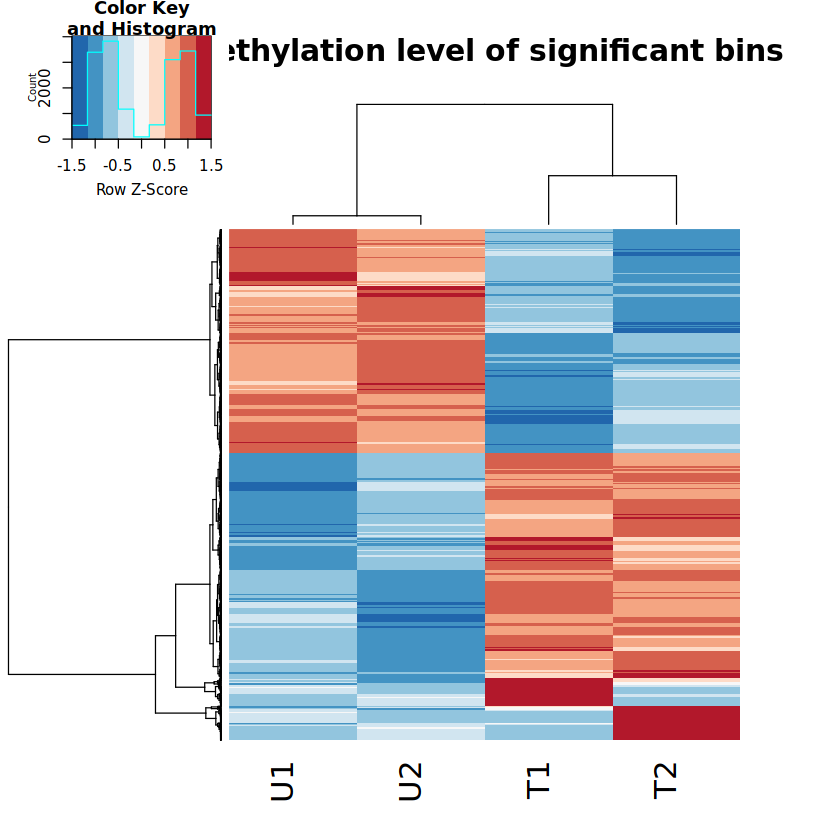

In [26]:
# %%R 
plotHeatMap(radar_sig)

There are 4144 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



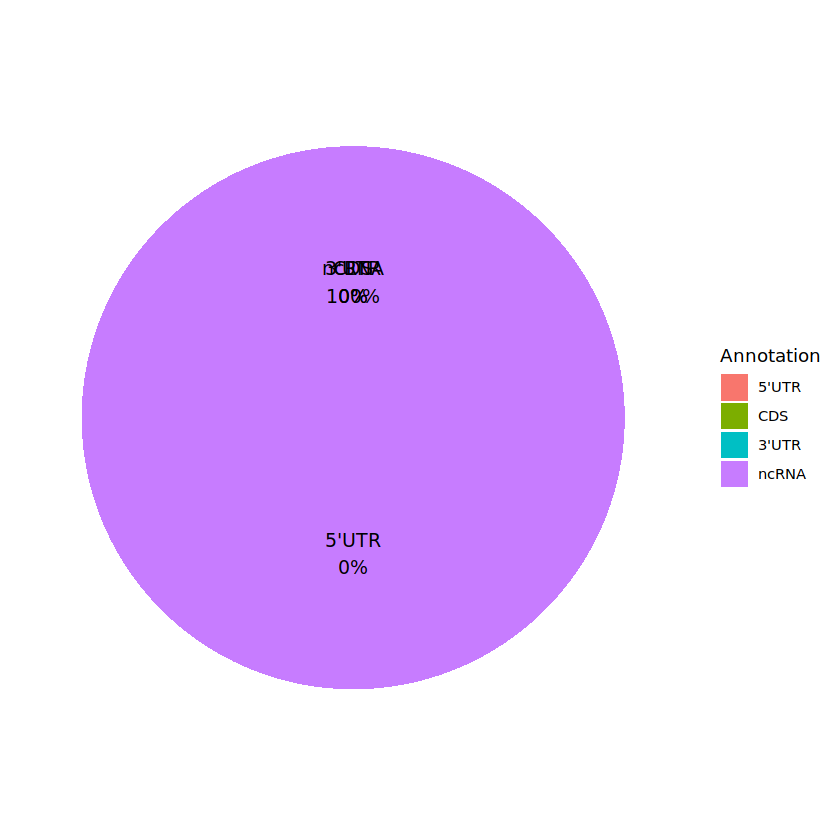

In [27]:
# %%R 
peakDistribution(radar_sig)

___
## Save results into files

In [28]:
# %%R 
suppressMessages(suppressWarnings(library (tidyverse)))

In [29]:
GTF

[1] "../../scallop-genome/DAC_GRCh37_merged.gtf"

In [30]:
# %%R 
gtf <- rtracklayer::import(GTF)

# gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')
# message ('-> GTF loaded!')

# add_Name <- function(res, gene2name){
#     res$ensembl <- res$name %>% as.character
#     res$name <- gene2name[res$ensembl %>% as.character,]
#     return (res)
# }

In [37]:
# result_sig %>% filter(grepl('DAC',name))

In [38]:
result_all %>% filter(grepl('DAC',name))

chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<dbl>,<dbl>
chr1,85718376,85724246,DAC.12-x1-0,0,-,85718376,85724246,0,2,"10,40","0,5831",0.03138160,0.9502750878
chr1,85724297,85724346,DAC.12-x1-0,0,-,85724297,85724346,0,1,50,0,2.25129180,0.1864916032
chr7,23340604,23347503,DAC.157-x1-0,0,+,23340604,23347503,0,2,"33,17","0,6883",-0.08961216,0.9680716636
chr8,142146634,142146683,DAC.198-x1-0,0,+,142146634,142146683,0,1,50,0,-0.99212880,0.4989123692
chr9,74586496,74587618,DAC.204-x1-0,0,+,74586496,74587618,0,2,"39,11","0,1112",-3.80666249,0.1681170576
chr11,65306424,65306473,DAC.222-x1-0,0,-,65306424,65306473,0,1,50,0,-2.18953223,0.4515358915
chr11,110171085,110171134,DAC.223-x1-0,0,-,110171085,110171134,0,1,50,0,-1.38629436,0.2881648875
chr12,1192346,1192695,DAC.230-x1-0,0,+,1192346,1192695,0,1,350,0,1.34013232,0.0004329188
chr12,1192746,1219431,DAC.230-x1-0,0,+,1192746,1219431,0,3,"1,75,74","0,21170,26612",1.65490028,0.4220921244


In [39]:
# %%R
write.table(result_all %>% filter(grepl('DAC',name)), file = "radar_scallop/result.all.txt",row.names=F, sep='\t', quote=FALSE) 
# write.table(result_sig %>% filter(grepl('DAC',name)), file = "radar_scallop/result.sig.txt",row.names=F, sep='\t',quote=FALSE) 

In [40]:
# cp -v radar/result.sig.txt hl60_delta_mtyl_table.txt 

In [41]:
# !cat hl60_delta_mtyl_table.txt | head 

### Save results into `bed12` format 
`tidyverse` can not be loaded while using RADAR!

In [42]:
# save bed 12 format 
names(result_all)[1] <- paste0("# ", names(result_all)[1])
write.table(result_all %>% dplyr::select(c(1:12)) %>% filter(grepl('DAC',name)), file = "radar_scallop/result.all.bed",row.names=F, sep="\t", quote=FALSE) 

In [43]:
# save bed 12 format 
names(result_sig)[1] <- paste0("# ", names(result_sig)[1])
write.table(result_sig %>% dplyr::select(c(1:12)) %>% filter(grepl('DAC',name)), file = "radar/result.sig.bed",row.names=F, sep='\t',quote=FALSE)

In [44]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/mamba/envs/radar/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] forcats_0.5.0            stringr_1.4.0            dplyr_0.8.5             
 [4] purrr_0.3.4              readr_1.3.1              tidyr_1.0.2             
 [7] tibble_3.2.1             tidyverse_1.2.1          RADAR_0.2.4             
[10] qvalue_2.16.

In [45]:
date()

[1] "Mon Sep  4 05:06:57 2023"